In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import Dataloader, MnistSpikesDataloader
from spiking import iterate_spikes
from spiking.layers import IntegrateAndFireLayer
from spiking.evaluation import SpikingClassifierEvaluator
from spiking.utils import load_model, save_model

In [55]:
image_shape = (16, 16)
num_outputs = 1024
threshold_mean = 25.0

dataloader = MnistSpikesDataloader("../data/mnist-subset", 'train', image_shape=image_shape)
test_dataloader = MnistSpikesDataloader("../data/mnist-subset", 'test', image_shape=image_shape)
max_x, max_y = dataloader.inputs[0].shape
max_z = 2
max_input_spikes = max_x * max_y * max_z
print(f"{max_input_spikes = }")

model_checkpoint_name = f'model_lin_{num_outputs}_outs_{threshold_mean}_th_mean_{image_shape[0]}x{image_shape[1]}'
print(f"{model_checkpoint_name = }")

max_input_spikes = 512
model_checkpoint_name = 'model_lin_1024_outs_25.0_th_mean_16x16'


In [56]:
def dataloader_to_spike_times(model: IntegrateAndFireLayer, arg_dataloader: Dataloader):
    X, y = [], []
    for batch_idx, (spikes, label, _) in enumerate(arg_dataloader.iterate(batch_size=1), start=1):
        for incoming_spikes, current_time, dt in iterate_spikes(spikes, shape=(max_z, max_x, max_y)):
            model.forward(incoming_spikes.flatten(), current_time=current_time, dt=dt)
        X.append(model.spike_times)
        y.append(label)
        model.reset()
    return X, y

def eval_snn(
    model: IntegrateAndFireLayer, classif=None, train: bool = False, visualize: bool = True, verbose: bool = True
):
    return (
        SpikingClassifierEvaluator(model, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
            .eval_classifier(classifier=classif, train=train, visualize=visualize, verbose=verbose)
    )

def visualize_weights(model, neurons_indices=None, per_row: int = 4):
    if neurons_indices is None:
        neurons_indices = range(model.num_outputs)

    for idx, neuron_idx in enumerate(neurons_indices, start=1):
        img = model.weights[neuron_idx].reshape((max_z, max_x, max_y))
        padding = torch.zeros((1, max_x, max_y), device=img.device)
        img = torch.cat([img, padding], dim=0)
        img = img.permute(1, 2, 0).detach().cpu().numpy()

        if idx % per_row == 1:
            plt.figure(figsize=(15, 5))
        plt.subplot(1, per_row, ((idx - 1) % per_row) + 1)
        plt.title(f"Weights {neuron_idx}")
        plt.axis("off")
        plt.imshow(img)

        if idx % per_row == 0:
            plt.show()

    if len(neurons_indices) % per_row != 0:
        plt.show()

In [57]:
model_test: IntegrateAndFireLayer = load_model(f'../checkpoints/{model_checkpoint_name}.pkl')

In [58]:
classif = SpikingClassifierEvaluator(model_test, dataloader, test_dataloader, shape=(max_z, max_x, max_y))
X_train, y_train = classif.X_train, classif.y_train
X_test, y_test = classif.X_test, classif.y_test

Train metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


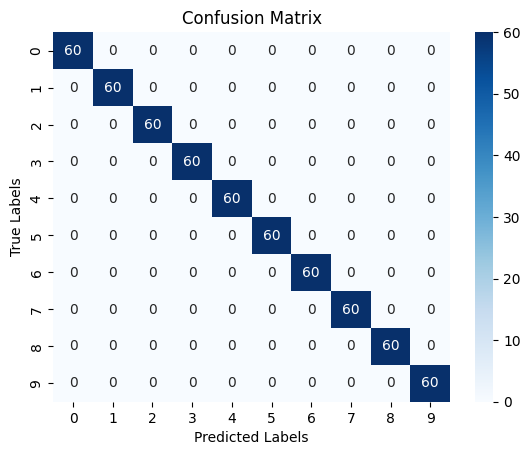


Validation metrics:
Accuracy: 0.79
Precision: 0.85
Recall: 0.79
F1 Score: 0.80


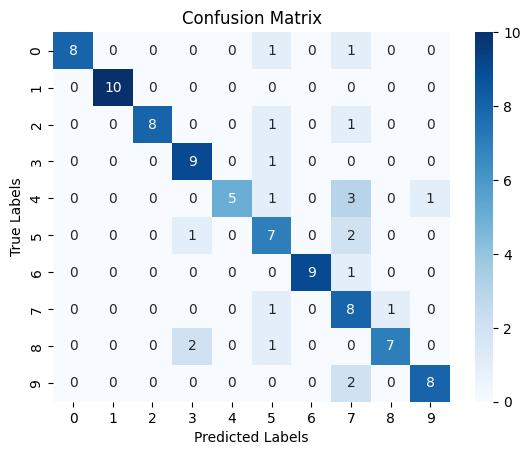

((1.0, 1.0, 1.0, 1.0), (0.79, 0.8496794871794873, 0.79, 0.801000194821705))

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

model = RandomForestClassifier(random_state=42)
eval_snn(model_test, classif=model, train=True, visualize=True, verbose=True)

In [60]:
importances = model.feature_importances_
importances

array([0.00095457, 0.00017901, 0.        , ..., 0.00081707, 0.        ,
       0.        ])

(array([755.,  80.,  55.,  27.,  30.,  19.,  12.,   5.,   7.,   6.,   5.,
          5.,   1.,   2.,   1.,   5.,   1.,   1.,   1.,   0.,   2.,   0.,
          0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.00072442, 0.00144884, 0.00217326, 0.00289768,
        0.00362209, 0.00434651, 0.00507093, 0.00579535, 0.00651977,
        0.00724419, 0.00796861, 0.00869303, 0.00941744, 0.01014186,
        0.01086628, 0.0115907 , 0.01231512, 0.01303954, 0.01376396,
        0.01448838, 0.0152128 , 0.01593721, 0.01666163, 0.01738605,
        0.01811047, 0.01883489, 0.01955931, 0.02028373, 0.02100815,
        0.02173256]),
 <BarContainer object of 30 artists>)

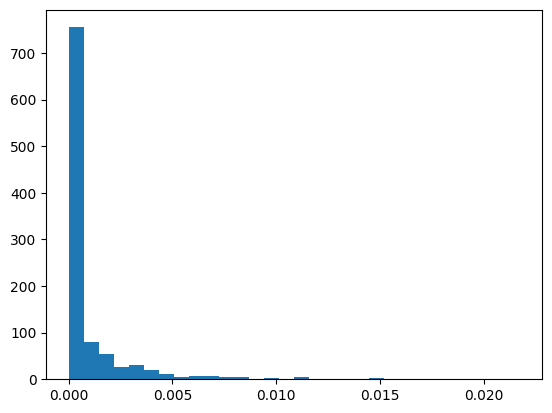

In [61]:
plt.hist(importances, bins=30)

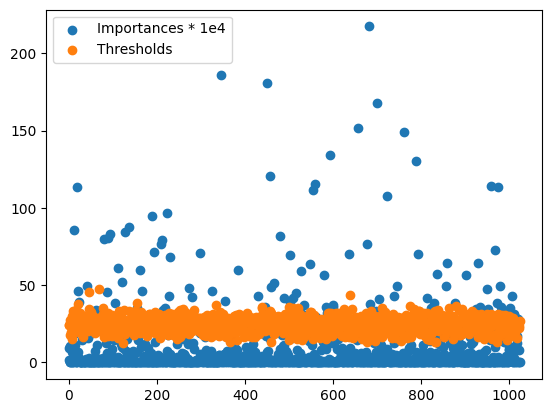

In [62]:
X = np.arange(len(importances))
plt.scatter(X, importances * 1e4, label="Importances * 1e4")
plt.scatter(X, model_test.thresholds, label="Thresholds")
plt.legend()

Text(0, 0.5, 'Feature Importance')

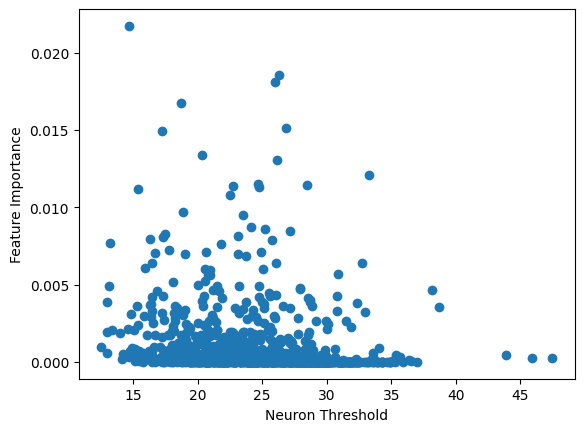

In [63]:
plt.scatter(model_test.thresholds, importances)
plt.xlabel("Neuron Threshold")
plt.ylabel("Feature Importance")

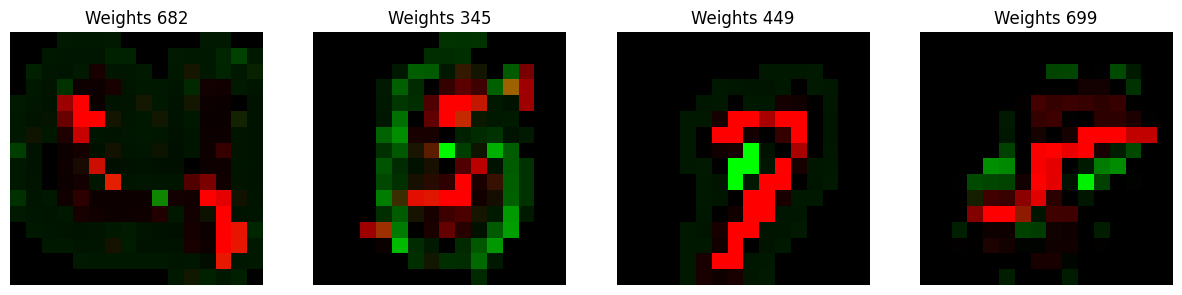

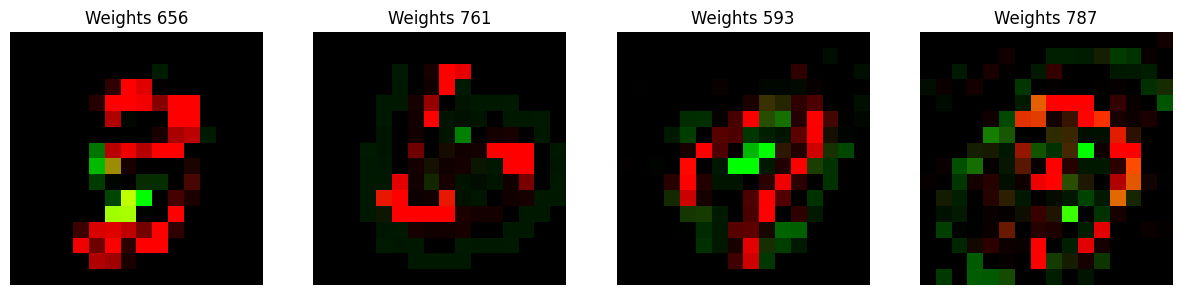

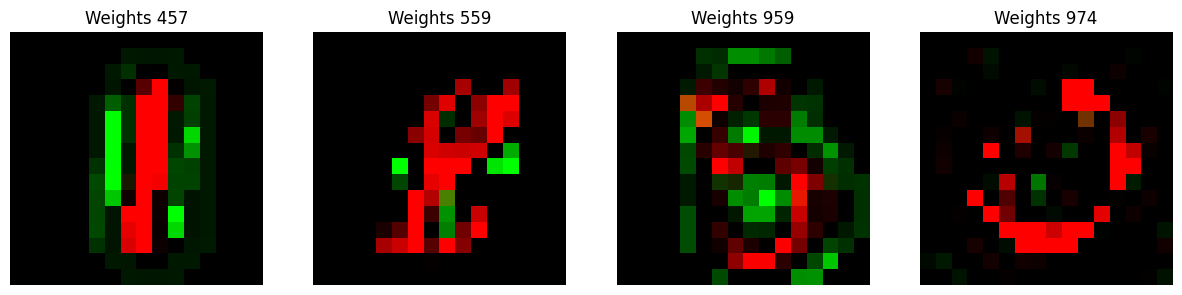

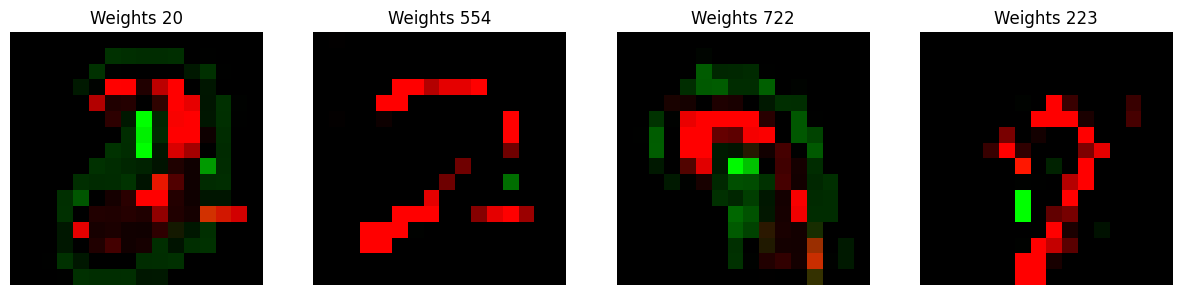

In [64]:
indices = np.argsort(importances)[-16:][::-1]
visualize_weights(model_test, neurons_indices=indices, per_row=4)